In [1]:
import numpy as np

from MAGPy_RV import MCMC_aux.get_model as get_model
from MAGPy_RV import Parameters as par
from MAGPy_RV import Models as mod
from MAGPy_RV import Kernels as ker
from MAGPy_RV import GP_Likelihood as gp
from MAGPy_RV import MCMC.run_MCMC as run
from MAGPy_RV import plotting as plot
from MAGPy_RV from saving import save
from MAGPy_RV import auxiliary as aux

2813.2308006313287 16620.585819951895


## Creating fake data to work with
Much like before, a cosine with a small jitter term is created as a fake set of data, this will act as the activity to model our kernel from

In [2]:
# time array with 20 values
time = np.arange(0,20,1)
# set up the amplitude and period of the cosine
A = 10.
P = 5.
err = []
# set up a random jitter to add to the data
for i in time:
    err.append(np.random.uniform(-3,3))
# generate the rvs and errors
rv = A*np.cos(time*((2*np.pi)/P))+err
rv_err = np.ones_like(rv)*3

We will additionally now add to this data by creating a polynomial and adding it on to our rv values to simulate activity plus some polynomial signal

In [3]:
# the polynomial we use will be y = 0.2x^2 + x -10, the polynomial model can take up to x^3
a0 = 5.
a1 = 1.
a2 = 0.2
a3 = 0
# create the polynomial and add it to the rv data
y = a3*(time**3) + a2*(time**2) + a1*time + a0
rv = rv + y

data_plot function will take the time, rv data, and rv errors and plot a scatter graph of the data, similar to before but now the polynomial part is visible. Axis labels, legend, and saving can all be controlled from the function inputs.

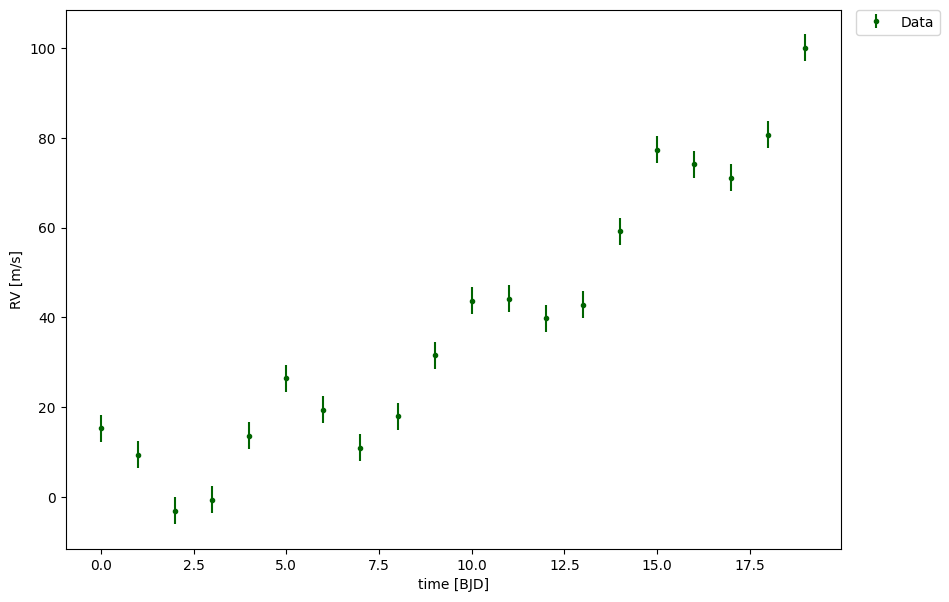

In [4]:
plot.data_plot(time = time, rv = rv, y_err = rv_err)

## Creating the kernel
A cosine Kernel is created the same as before using the par_create funciton which will take only the name of the kernel and return an empty dictionary of hyperparameters to be filled out. This dictionary can be printed to view the hyperparamer names.

Currently available kernels along with their hyperparameter names can be viewed by running PrintKernelList:

In [5]:
ker.PrintKernelList()

Implemented kernels:
{'Cosine': ['gp_amp', 'gp_per'], 'ExpSquared': ['gp_amp', 'gp_timescale'], 'ExpSinSquared': ['gp_amp', 'gp_timescale', 'gp_per'], 'QuasiPer': ['gp_per', 'gp_perlength', 'gp_explength', 'gp_amp'], 'JitterQuasiPer': ['gp_per', 'gp_perlength', 'gp_explength', 'gp_amp', 'gp_jit'], 'Matern5/2': ['gp_amp', 'gp_timescale'], 'Matern3/2': ['gp_amp', 'gp_timescale', 'gp_jit']}


In [6]:
# create the kernel
hparam = par.par_create("Cosine")
# print the hyperparameter dictionary
print(hparam)

{'gp_amp': 'gp_amp', 'gp_per': 'gp_per'}


Hyperparameters are then assigned in the same way as before but this time we give the errors and whether we want the value to vary in the mcmc. By default vary is set to True and the errors are 20% of the value.

In [7]:
# assign values to the dictionary
hparam["gp_amp"] = par.parameter(value = 10., error = 0.5, vary = True)
hparam["gp_per"] = par.parameter(value = 5., error = 0.5, vary = True)
# printing now prints the filled dictionary
print(hparam)

{'gp_amp': Parameter object: value = 10.0, error=0.5 (vary = True) 
, 'gp_per': Parameter object: value = 5.0, error=0.5 (vary = True) 
}


Priors should then be created by pri_create function and appending it to the list of priors in the same way as before. The pri_create function takes the parameter name, the prior name, and the prior parameters as inputs which must be inputted in the correct form, this form can be viewed by running the PRINTPRIORDER function.

In [8]:
# view the correct form of prior parameter inputs
par.PRINTPRIORDER()

Gaussian: List should take the form [mu, sigma] where all values are floats or ints 
Jeffery: List should take the form [minval, maxval] where all values are floats or ints 
Modified Jeffery: List should take the form [minval, maxval, kneeval] where all values are floats or ints 
Uniform: List should take the form [minval, maxval] where all values are floats or ints


In [9]:
# create empty prior list
prior_list = []
# uniform parameters used here so prior parameters inputted as [minval, maxval], as the above function states
pri_amp = par.pri_create("gp_amp", "Uniform", [5.,15.])
# then append the prior to the list
prior_list.append(pri_amp)
pri_per = par.pri_create("gp_per", "Uniform", [0.,10.])
prior_list.append(pri_per)
# print the list of all the priors
print(prior_list)

[('gp_amp', 'Uniform', {'minval': 5.0, 'maxval': 15.0}), ('gp_per', 'Uniform', {'minval': 0.0, 'maxval': 10.0})]


## Model Parameters
Now the data contains a polynomial model, we must set up initial parameters for this model to supply to the mcmc and allow us to plot the model.

We will start by defining a model list that contains the name of all models present in the data, in this case this will just be a polynomial. Running PrintModelList will allow us to see all the available models and their parameter names. We then create the model parameter dictionary by running the mod_create function with the model list as the only input. We can then print this to view the required parameters.

In [10]:
# see available models
mod.PrintModelList()

Implemented models
{'No_Model': ['rvs'], 'Offset': ['rvs', 'offset'], 'Polynomial': ['a0', 'a1', 'a2', 'a3'], 'Keplerian': ['time', 'P', 'K', 'ecc', 'omega', 't0']}


In [11]:
# define the model list, in this case just polynomial
model_list = ["Polynomial"]
# create the model parameter dictionary
model_par = mod.mod_create(model_list)
print(model_par)

{'a0': 'a0', 'a1': 'a1', 'a2': 'a2', 'a3': 'a3'}


We must then define model parameters and priors in the same way as for the kernel using the parameter function and the pri_create function

In [12]:
# initial parameter values are set up for the model
model_par["a0"]=par.parameter(value = 5., error=1., vary=True)
model_par["a1"]=par.parameter(value = 1., error=0.5, vary=True)
model_par["a2"]=par.parameter(value = 0.2, error=0.1, vary=True)
# we know a3 is 0 so there is no need to vary it in the mcmc but we must still provide an error
model_par["a3"]=par.parameter(value = 0., error = 0.1, vary=False)
# priors created in the same way as before
pri_val = par.pri_create("a0", "Uniform", [0.,10.])
prior_list.append(pri_val)
pri_val = par.pri_create("a1", "Uniform", [0.,3.])
prior_list.append(pri_val)
pri_val = par.pri_create("a2", "Uniform", [0.,1.])
prior_list.append(pri_val)
# printing the final prior list and model parameters
print("Prior List:")
print(prior_list)
print("Model Parameters:")
print(model_par)

Prior List:
[('gp_amp', 'Uniform', {'minval': 5.0, 'maxval': 15.0}), ('gp_per', 'Uniform', {'minval': 0.0, 'maxval': 10.0}), ('a0', 'Uniform', {'minval': 0.0, 'maxval': 10.0}), ('a1', 'Uniform', {'minval': 0.0, 'maxval': 3.0}), ('a2', 'Uniform', {'minval': 0.0, 'maxval': 1.0})]
Model Parameters:
{'a0': Parameter object: value = 5.0, error=1.0 (vary = True) 
, 'a1': Parameter object: value = 1.0, error=0.5 (vary = True) 
, 'a2': Parameter object: value = 0.2, error=0.1 (vary = True) 
, 'a3': Parameter object: value = 0.0, error=0.1 (vary = False) 
}


## Obtaining LogL and GP values
As we are using a model, in order to run the GPLikelihood class we require the y values for the model. The get_model function allows the y values to be obtained for all models in the data given their parameters, names, and a time array. For plotting purposes this time array is better to be far smoother than the actual time array to produce a good plot. The GPLikelihood class should this time be defined and run with the time data, the rv data, the rv errors, the hyperparameters, the kernel name, the model y values, and the model parameters. This allows the GPLikelihood.LogL function to be run with the prior_list which returns the initial log likelihood of the GP model.

In order to return the y values and errors of the GP model, a predicted x array must first be defined which should be smoother and longer than the initial time array, in this case it begins at -1 and ends at 21 with intervals of 0.1 which is around 10 times more data points than the initial time array. This must be then inputted into the GPLikelihood.predict function to return the y values and the errors of the GP.

In [13]:
# model_y in this case comes only from the polynomial in the data
model_y = get_model(model_list, time, model_par, to_ecc=False)
# GPLikelihood class called as loglik, run with the current inputs
loglik = gp.GPLikelihood(time, rv, rv_err, hparam, "Cosine", model_y, model_par)
# LogL obtained by running loglik.LogL with the prior_list as the only input
logL = loglik.LogL(prior_list)
# xpred is smoother and longer than time
xpred = np.arange(min(time)-1, max(time)+1, 0.1)
# GP_y and GP_err are arrays of the GP y values and errors of the same length as the xpred array
GP_y, GP_err = loglik.predict(xpred)
print('Initial Log Likelihood =', logL)

Initial Log Likelihood = -48.386799066089694


## Plotting the GP
The GP y values and model y values could be manually plotted against xpred once obtained in the previous step however the GP_plot function allows for an alternative faster way of plotting. This time, we must give the time array, the rv data, the hyperparameters, the kernel name, the rv errors, the model list, and the model parameters. This will now return a plot of the data with the GP plotted over it in orange and the combined model and GP plotted in blue along with its uncertainties in grey. Xpred, axis labels, residuals, legend, and saving can all be controlled by the function inputs.

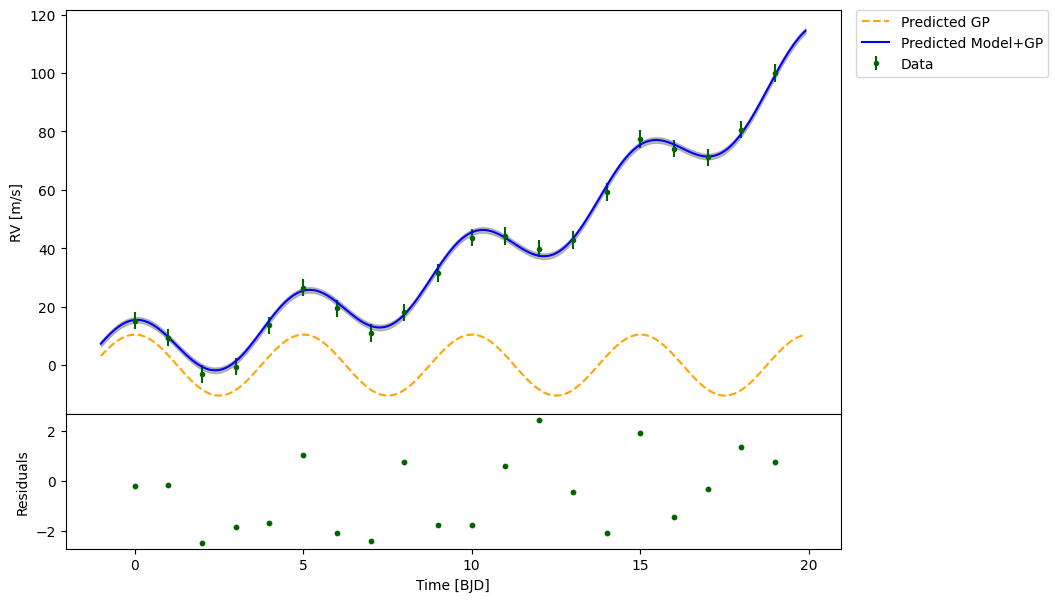

In [14]:
# GP_plot will plot the GP, the model and the data along with residuals if enabled and the uncertainty in grey
plot.GP_plot(time, rv, hparam, "Cosine", rv_err = rv_err, model_list = model_list, model_param = model_par, residuals = True)

## Running the MCMC
The MCMC can be run by defining the run_MCMC function as 4 outputs: the first is the LogL chain, this will be a 3d array of the log likelihood across all iterations and chain; the second is the final hyperparameters, this will be a 3d array of all hyperparameters where ncolumns = parameters, nrows = chains, and ndimensions = iterations; the third is the final model parameters, this will be a 3d array of all model parameters where ncolumns = parameters, nrows = chains, and ndimensions = iterations; the fourth is the completed iterations, this will be the number of iterations that the code ran for, this may not be the number that was set as it may reach convergence before that number is reached.

This function requires the inputs of iterations, the time array, the rv data, the rv error, the hyperparameters, and the kernel name. For this run, as there is a model we will also include the model parameters, the model list, the prior list, and the number of chains. If the number of chains is not entered it defaults to 100.

This function will print the initial parameters and hyperparameters, the initial log likelihood, the number of chains, the progress, the number of completed iterations, the acceptance rate, and the time taken.

In [15]:
# set up iterations and chains
iterations = 100
numb_chains = 100
# run the mcmc function to return the 3d parameter arrays
logL_chain, fin_hparams, fin_model_param, completed_iterations = run(iterations, time, rv, rv_err, hparam, "Cosine", model_par, model_list, prior_list, numb_chains = numb_chains)

Initial hyper-parameter guesses: 
[10.0, 5.0]

Initial model parameter guesses (ecc and omega are replaced by Sk and Ck): 
[5.0, 1.0, 0.2, 0.0]

Initial Log Likelihood:  -48.386799066089694

Number of chains:  100

Start Iterations

Progress:  |██████████████████████████████████████████████████| 100.0% Complete


100 iterations have been completed with 100 contemporaneous chains

Acceptance Rate =  0.2514851485148515
 ---- 0.05667688051859538 minutes ----


## Mixing Plots
The mixing_plot funciton takes in the hyperparameter array, the kernel name, the parameter array, the model list, and the logL array. It returns the MCMC chains for each parameter where if the code had run for a sufficient number of iterations it should be possible to see some convergence in the chains. This plot can be saved through the function inputs. This plot and the next will still plot the parameters that are not set to vary however they will easily be visible in the mixing plots by the straight lines as they are not varying. These plots do not reach convergence as very few iterations were used and the priors were likely too large.

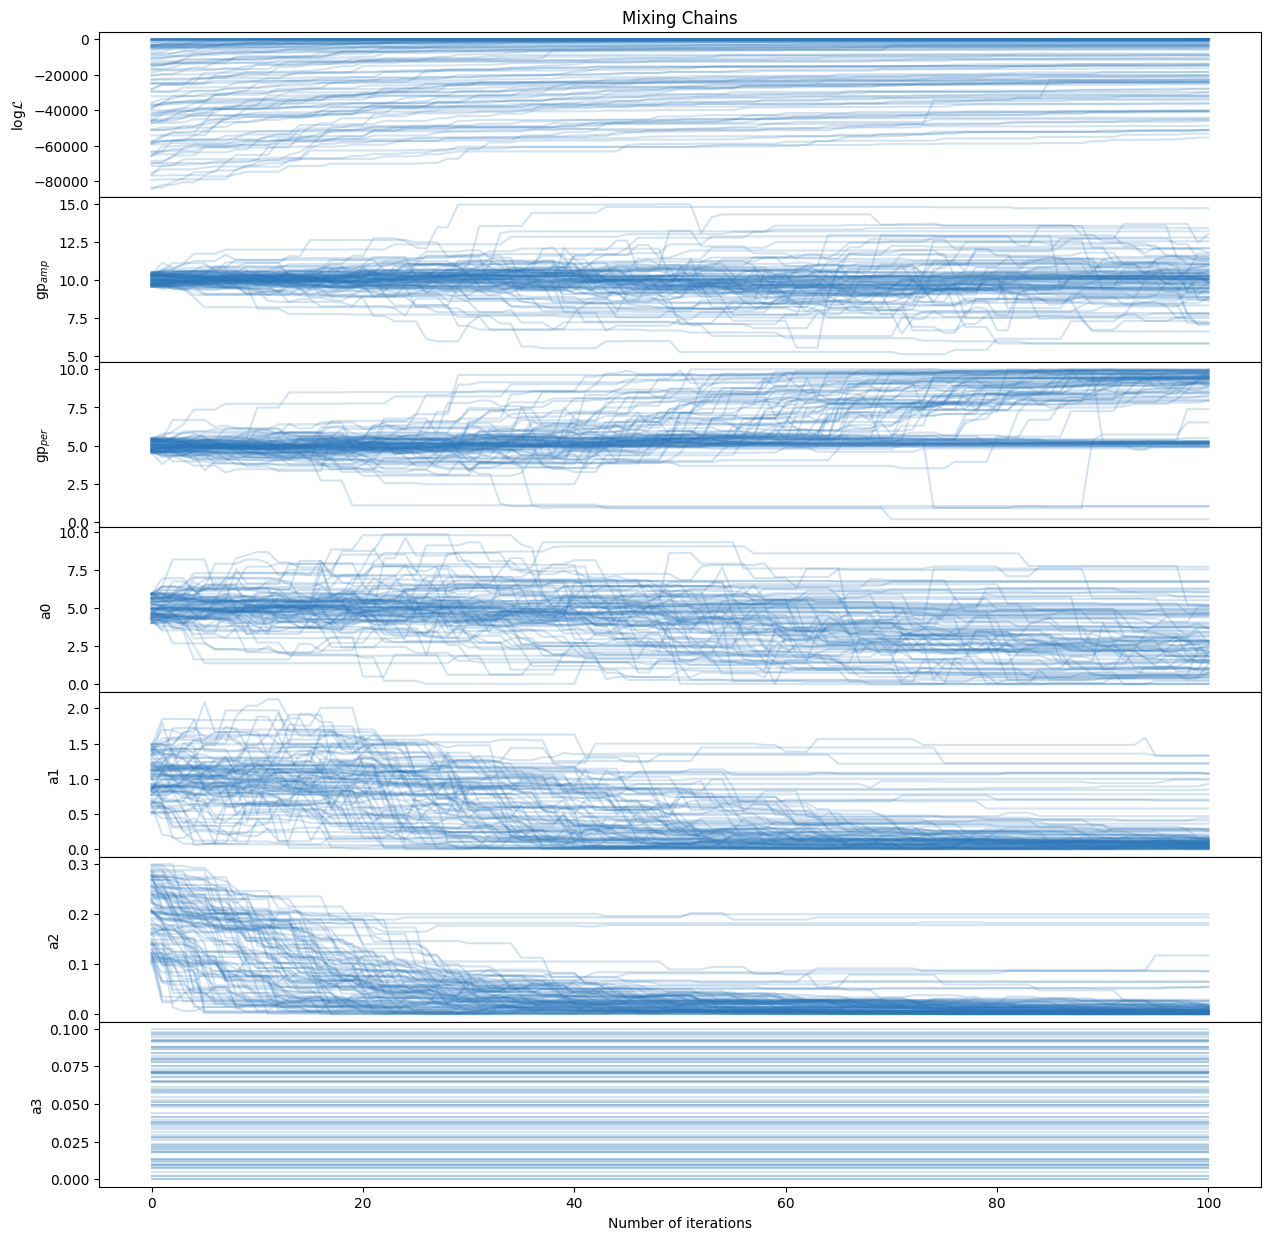

In [16]:
# show the mixing plots, in this case a_3 does not vary as we set it to not do so
plot.mixing_plot(fin_hparams, "Cosine", fin_model_param, model_list, logL_chain)

## Corner Plots
The corner_plot function takes the same inputs as the mixing plot function minus the logL array and will return 3 outputs. The first is a list of the final posterior values for each parameter and hyperparameter, the second and third are the upper and lower errors on thos values. These values are also all visible on top of each corner plot. This plot can also be saved through the function inputs.

The code will produce seperate plots for the hyperparameters, model parameters, and combined. These will also save individually.

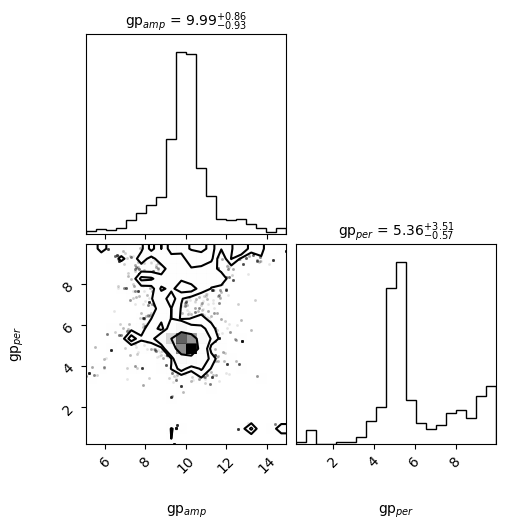

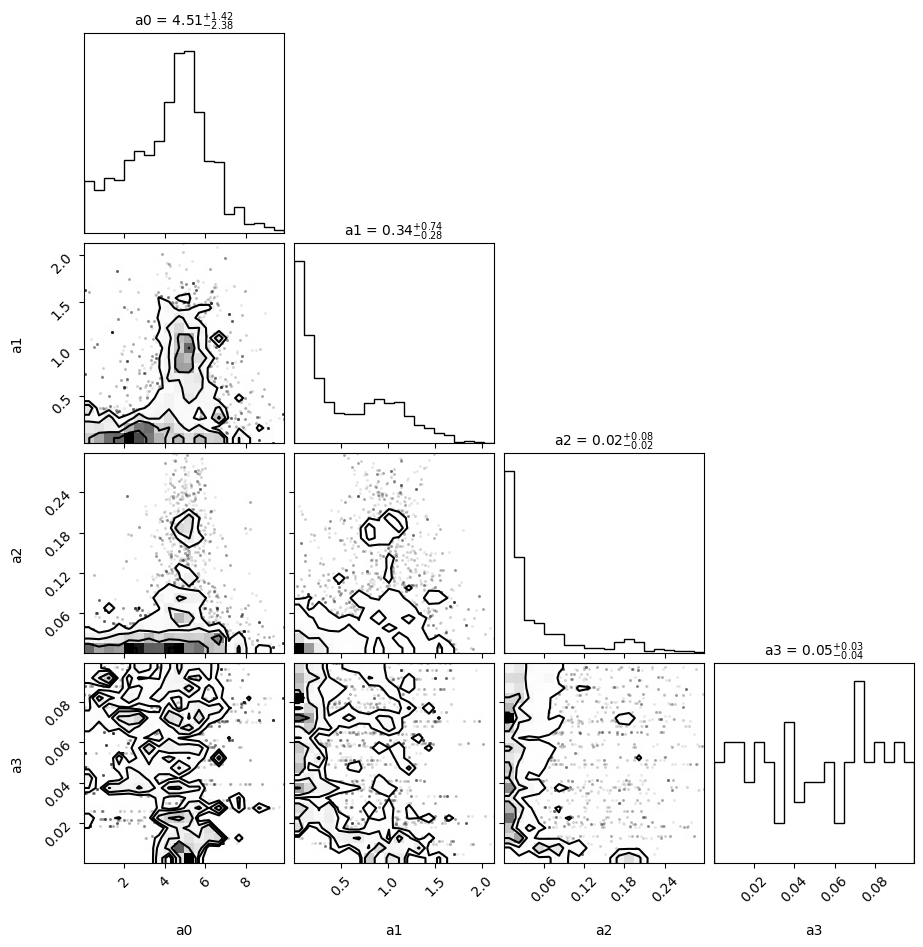

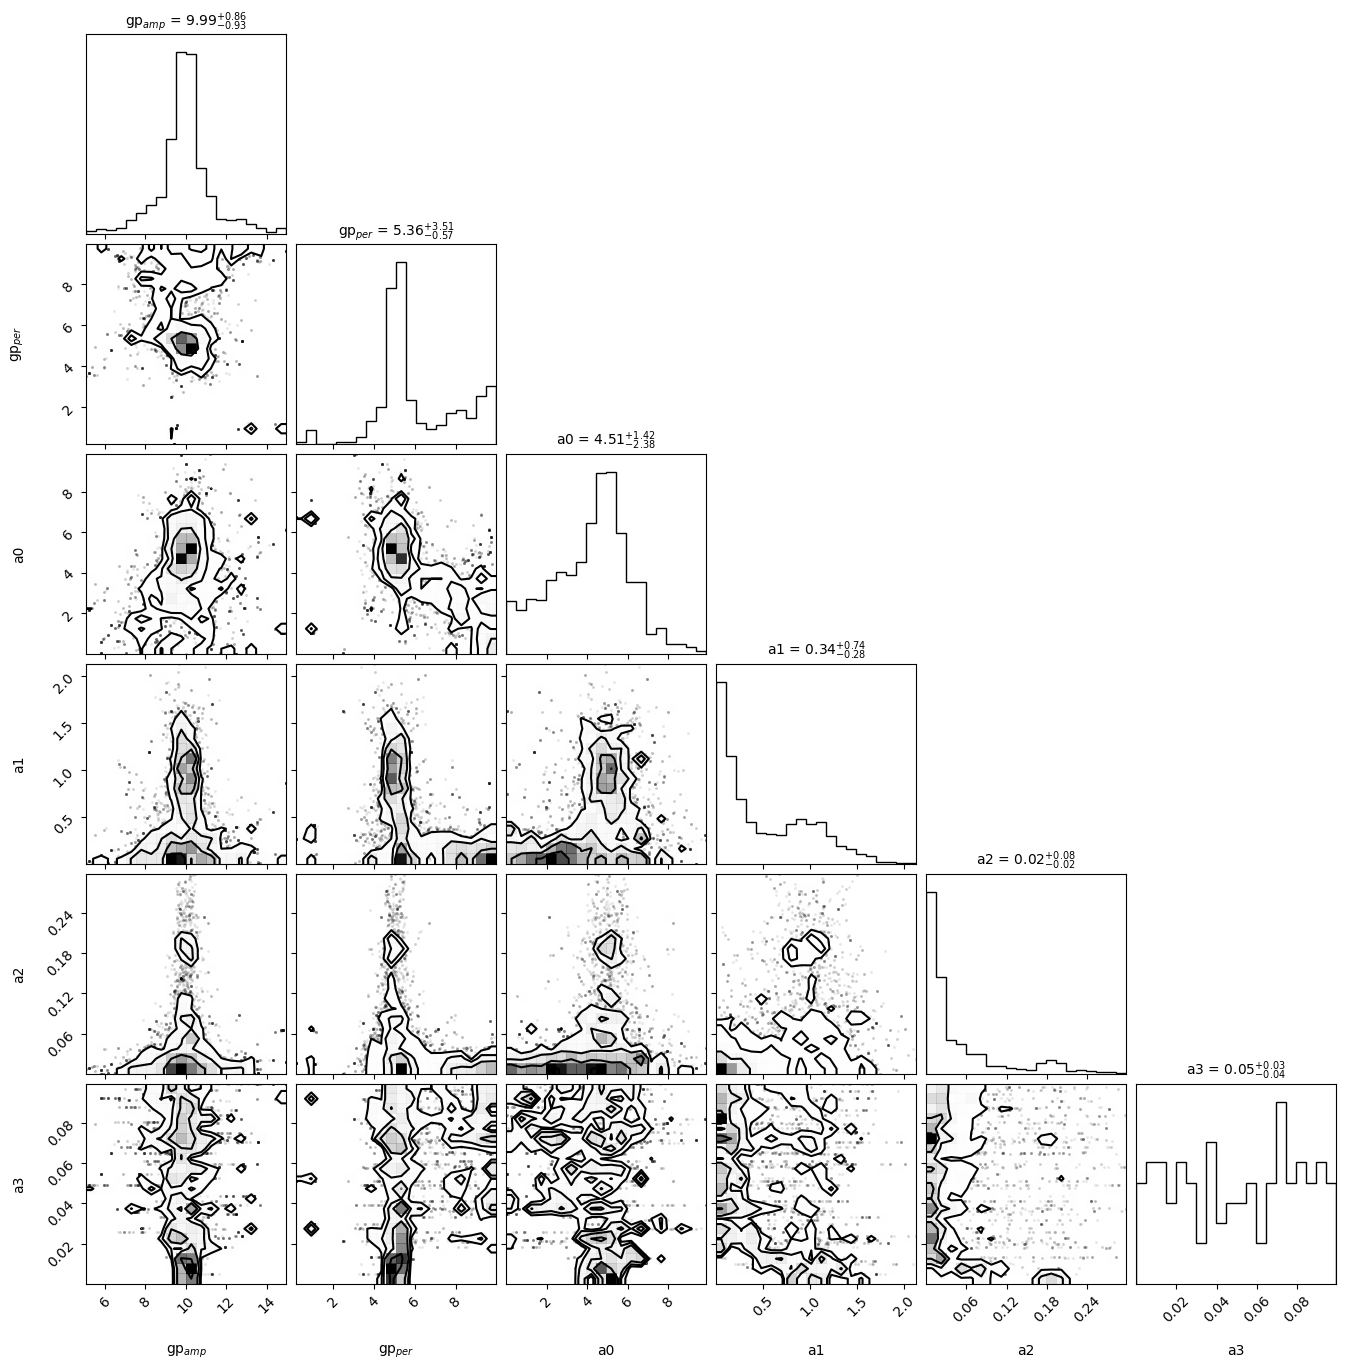

Parameter values after MCMC:  [9.985849947307976, 5.355020293768974, 4.510419108459403, 0.3443697513016505, 0.022545357525885573, 0.051952411832212816]


In [17]:
# corner plots also look poor in this case as only 100 iterations were run
final_param_values, final_param_erru, final_param_errd = plot.corner_plot(fin_hparams, "Cosine", fin_model_param, model_list, errors=True)

## Saving
The save function will save all outputs, initial conditions, final conditions, and posteriors in seperate files in a chosen folder. If this folder does not exist a new one will be created. These are all generated from the previous functions and shouold be inputted as done below. The input burnin is optional and will save the posteriors with the desired burn in, the input fin_to_skck defaults to False and is for Keplerians, this determines whether to return the final parameters as Sk and Ck (True) or ecc and omega (False). As well as a readable list of final parameter values, the function will output the parameter values in the form of a latex table in the file 'final_param_table'.

In [18]:
# enter in desired file path to saving function
save('/file/path/folder-name/', rv, time, rv_err, model_list = model_list, init_param = model_par, kernel = 'Cosine', init_hparam = hparam, prior_list = prior_list, fin_hparam_post = fin_hparams, fin_param_post = fin_model_param, logl_chain = logL_chain, fin_param_values = final_param_values, fin_param_erru = final_param_erru, fin_param_errd = final_param_errd, burnin = 20, fin_to_skck = False)